In [1]:
import mne
import os.path as op
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#data_path = op.join('C:/Users/csilv/Desktop/UNB Gama/7 Semestre/Processamento de Sinais/Normal_Subject_01.edf') #Define data_path
data_path = op.join('D:/My Drive/Estudos/Engenharia Eletrônica - UnB/7º semestre/Processamento de Sinais/Projeto Final/Dataset/Normal_Subject_01.edf')
raw = mne.io.read_raw_edf(data_path) #read raw data

Extracting EDF parameters from D:\My Drive\Estudos\Engenharia Eletrônica - UnB\7º semestre\Processamento de Sinais\Projeto Final\Dataset\Normal_Subject_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
raw.info['chs'][0]['kind'] = 202
raw.info['chs'][1]['kind'] = 202
raw.info['chs'][2]['kind'] = 202
raw.info['chs'][3]['kind'] = 202
raw.info['chs'][18]['kind'] = 202
raw.info['chs'][19]['kind'] = 202

In [4]:
raw.info['bads'] = ['EMG', 'EMG1', 'EMG2', 'ECGII']

In [5]:
picks = mne.pick_types(raw.info, eeg=True, eog= True, exclude = raw.info['bads'])

Effective window size : 8.000 (s)


<ipython-input-6-ea26a4a30767>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  without_filter = raw.plot_psd(fmax = 60)


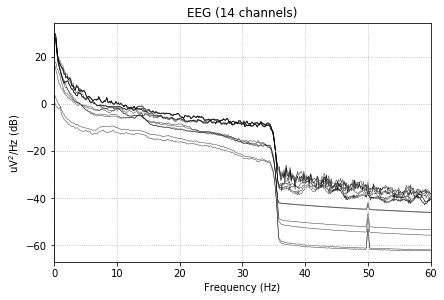

In [6]:
without_filter = raw.plot_psd(fmax = 60)

In [7]:
raw.load_data()
raw.notch_filter(np.arange(50, 100, 50), picks=picks, fir_design='firwin') #notch filter at 50, 100, 150 and 200

Reading 0 ... 7366399  =      0.000 ... 28774.996 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [8]:
#notch_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

In [9]:
raw.filter(None, 40., picks=picks, fir_design='firwin') # low pass filtering below 40 Hz'
#low_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 85 samples (0.332 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [10]:
raw.filter(1., None, picks=picks, fir_design='firwin') #high pass filtering above 1Hz
#high_pass_filter = raw.plot_psd(area_mode='range', picks=picks, average=False, tmax=10.0)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



<RawEDF  |  Normal_Subject_01.edf, n_channels x n_times : 24 x 7366400 (28775.0 sec), ~1.32 GB, data loaded>

In [11]:
raw.info['ch_names']

['EOG1',
 'EOG2',
 'EOG1A1',
 'EOG2A1',
 'C4A1',
 'C3A2',
 'F3',
 'F4',
 'C3',
 'C4',
 'A1',
 'A2',
 'O1',
 'O2',
 'ECGII',
 'EMG',
 'EMG1',
 'EMG2',
 'EOG1A2',
 'EOG2A2',
 'F3A2',
 'F4A1',
 'O1A2',
 'O2A1']

In [12]:
events = mne.make_fixed_length_events(raw, duration = 30.)

In [13]:
reject = dict(eeg = 150e-6, eog = 250e-6)

In [14]:
epochs = mne.Epochs(raw, events=events, picks=picks, reject=None, preload=True, tmin=-1.5, tmax=1.5) #Define trials

959 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 959 events and 769 original time points ...
1 bad epochs dropped


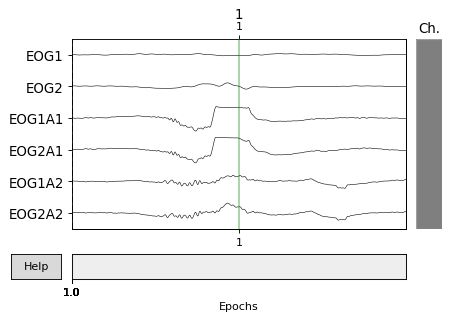

In [15]:
top = epochs[4].plot(picks=['EOG1A1', 'EOG1A2', 'EOG2A1', 'EOG2A2', 'EOG1', 'EOG2'])

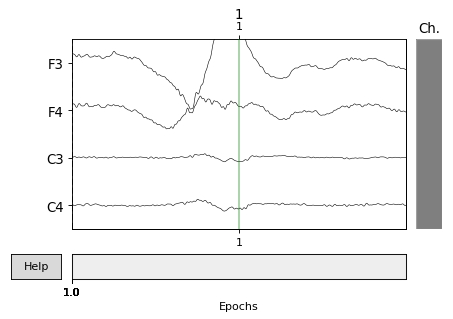

In [16]:
# 1. Decompose the data onto a set of components (i.e., rotate to new axes) using a BSS algorithm.

no_plot = epochs[4].plot(picks=['F3', 'F4', 'C3', 'C4'])

In [17]:
toSobi = epochs[4].get_data()

In [18]:
toSobi.shape

(1, 20, 769)

In [19]:
# %load sobi.py
import numpy as np
import itertools
import random

def time_lagged_cov(X, num_lags):

    N = X.shape[0]
    L = X.shape[1] - num_lags
    R = np.empty([num_lags,N,N])

    center = lambda x: x-x.mean(1)[:,None]

    X0 = center(X[:, 0:(0+L)])
    
    for k in range(num_lags):
        Xk = center(X[:,k:(k+L)])
        R[k] = (1.0/L)*(X0.dot(Xk.T))
        R[k] = 0.5*(R[k] + R[k].T)

    return R


def prewhiten(X):

    # subtract mean
    Xw = X - X.mean(1)[:, None]

    # Compute SVD
    U,s,V = np.linalg.svd(Xw, full_matrices=False)
    Sinv = np.linalg.pinv(np.diag(s))

    # Find principal components
    Q  = np.dot(Sinv, U.T)
    Xw = Q.dot(X)

    return Q, Xw


def submat_mul(X, i, j, R, multype='post'):

    if multype.lower() == 'post':
        idx_i = (..., i)
        idx_j = (..., j)
    elif multype.lower() == 'pre':
        idx_i = (..., i, slice(None))
        idx_j = (..., j, slice(None))

     # In place multiplication X*R
    col_i = X[idx_i]*1.0
    col_j = X[idx_j]*1.0
    X[idx_i] = R[0,0]*col_i + R[0,1]*col_j
    X[idx_j] = R[1,0]*col_i + R[1,1]*col_j

    return X

def max_eigvec(A):
    # Find eigenvector associated with largest eigenvalue
    [eigvals,v] = np.linalg.eigh(A)
    v = v[:,-1]
    return v

def generate_index_pairs(idx_range, random_order=True):
    ij_pairs = itertools.combinations(idx_range, 2)
    ij_pairs = list(ij_pairs)
    if random_order:
        random.shuffle(ij_pairs)
    
    return ij_pairs

def off(X):
    off_ = 0
    for x in X:
        off_ += (np.linalg.norm(x,ord='fro')**2 - np.linalg.norm(np.diag(x))**2)

    return off_/np.max(X)

def jd(X, eps=1.0e-6, random_order = True):

    """jointly diagonalize several matrices.

    Performs jacobi-like procedure to approximately diagonalize
    a set of matrices X

    Parameters
    ----------
    X : np.ndarray
        Has dimensions [num_matrices, num_rows, num_cols]
    eps : scalar, optional
        Stopping criterion based on eps tolerance, should be between 0 and infinity
    random_order : bool, optional
        If True, pivots will cycle randomly for givens rotations.
        May affect convergence rate but not the final soltuion

    Returns
    -------
    V : np.ndarray
        2D array containing diagonalizing transformation
        i.e. (V.T).dot( X ).dot( V ) will be approximately diagonal
    
    """

    X = np.atleast_3d(X)
    V = np.eye(X.shape[1])

    keep_going = True
    counter = 0
    off_val = []
    while keep_going:
        print('{}: {}'.format(counter, off(X)))
        counter += 1
        keep_going = False

        ij_pairs = generate_index_pairs(range(X.shape[1]), 
                                        random_order = random_order)
        
        for (i,j) in ij_pairs:
            # Extract submatrix
            idx = (slice(None), ) + np.ix_([i,j],[i,j])
            A = X[idx]*1.0

            # Find givens rotation matrix
            R = find_givens_rotation(A)

            if abs(R[0,1]) > eps: # sin_theta = R[0,1]
                keep_going = True 
                # Update X and V matrices

                # X' = R^T X R
                X = submat_mul(X, i, j, R, multype='post')
                X = submat_mul(X, i, j, R, multype='pre')

                # V = V R
                V = submat_mul(V, i, j, R, multype='post')

    return V

def find_givens_rotation(A):

    """
    Belouchrani, A., et al. “A Blind Source Separation Technique Using 
    Second-Order Statistics.” IEEE Transactions on Signal Processing: 
    A Publication of the IEEE Signal Processing Society, vol. 45, 
    no. 2, Feb. 1997, pp. 434–44, doi:10.1109/78.554307.

    See Appendix A
    """
    G   = np.array( [ A[:,0,0] - A[:,1,1], A[:,0,1] + A[:,1,0] ] )
    G   = np.atleast_2d(G).T
    GHG = np.dot(G.T, G)
    v = max_eigvec(GHG)
    
    v = np.sign(v[0])*v
    cos_theta = np.sqrt(0.5 + 0.5*v[0])
    sin_theta = -0.5*v[1]/(cos_theta)

    R = np.array([[ cos_theta,  -sin_theta],
                    [ sin_theta, cos_theta]])

    return R

def sobi(X, num_lags=None, eps=1.0e-6, random_order = True):

    """blind source separation technique using SOBI algorithm

    The "second-order blind source idenitification" algorithm is 
    a blind-source separation technique that works by jointly diagonalizing
    a set of time-lagged covariance matrices. 

    Parameters
    ----------
    X : np.ndarray
        Has dimensions [num_signals, num_samples]
    num_lags : int
        Number of time-lags to use in forming covariance matrices
    eps : scalar, optional
        Stopping criterion based on eps tolerance, should be between 0 and infinity
    random_order : bool, optional
        If True, pivots will cycle randomly for givens rotations.
        May affect convergence rate but not the final soltuion

    Returns
    -------
    S : np.ndarray
        2D array containing estimated source signals
    
    A : np.ndarray
        2D array containing mixing matrix
        i.e. A.dot(S) = X
    
    W : np.ndarray
        2D array containing unmixing matrix
        i.e. W.dot(X) = S
    
    """

    if num_lags is None:
        num_lags = np.minimum(1000, int(X.shape[1]/2))

    Q, Xw = prewhiten(X)

    R = time_lagged_cov(Xw, num_lags)

    V = jd(R*1.0, eps=eps)

    W = (V.T).dot(Q)
    A = np.linalg.pinv(W)
    S = W.dot(X)

    return S, A, W


    
    




In [20]:
[S, A, W] = sobi(toSobi[0])

0: 1.039505362248333
1: 0.8623427415503832
2: 0.8864372391683366
3: 0.8875364140959868
4: 0.8453868960331998
5: 0.8432282846809066
6: 0.8357077529567595
7: 0.840753048603058
8: 0.8409062203434421
9: 0.8442249213249462
10: 0.8462044128810651
11: 0.8486111132956393
12: 0.8504666975454718
13: 0.8518408821185002
14: 0.8569003844683667
15: 0.8562579242251225
16: 0.8595105485710444
17: 0.8627876996058114
18: 0.8622395830537039
19: 0.8653441711830017
20: 0.866343145867665
21: 0.8704635257039399
22: 0.8729415143497403
23: 0.8729456056791903
24: 0.8743548339160876
25: 0.877946001421997
26: 0.8798099064506044
27: 0.8807380391413331
28: 0.8816483665322403
29: 0.8846442764602443
30: 0.8857942422559526
31: 0.8894976738651664
32: 0.8903091301482503
33: 0.8925197121538213
34: 0.8927278352940113
35: 0.8966098827613009
36: 0.8987091850422033
37: 0.9018961245104913
38: 0.9038545120487095
39: 0.905862697904187
40: 0.9075091600597868
41: 0.9104410717276922
42: 0.9139289652105671
43: 0.9168177701385333
44:

In [21]:
S.shape

(20, 769)

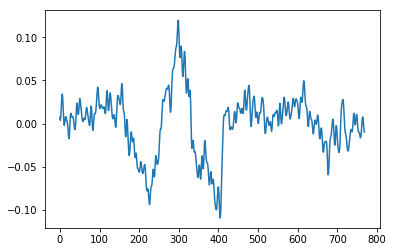

In [22]:
plt.plot(S[6])

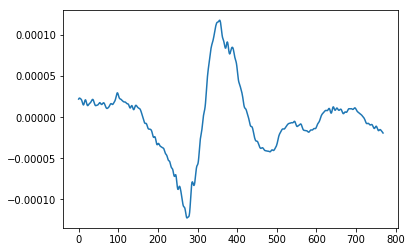

In [23]:
plt.plot(toSobi[0][6])

In [54]:
# 2. Reverse the sign on all lower and horizontal EOG channels (i.e., multiply signals by  1)
# and again decompose data onto components using a BSS algorithm. Flag those components that invert.

epochs.ch_names

['EOG1',
 'EOG2',
 'EOG1A1',
 'EOG2A1',
 'C4A1',
 'C3A2',
 'F3',
 'F4',
 'C3',
 'C4',
 'A1',
 'A2',
 'O1',
 'O2',
 'EOG1A2',
 'EOG2A2',
 'F3A2',
 'F4A1',
 'O1A2',
 'O2A1']

In [55]:
EOG_ch=[0, 1, 2, 3, 14, 15]

In [56]:
EOG_ch.type

AttributeError: 'list' object has no attribute 'type'

In [57]:
for n in EOG_ch:
    print(epochs.ch_names[n])

EOG1
EOG2
EOG1A1
EOG2A1
EOG1A2
EOG2A2


In [72]:
inv_EOG=epochs[4].get_data()

In [73]:
inv_EOG.shape

(1, 20, 769)

In [83]:
for n in EOG_ch:
    inv_EOG[0][n] = -inv_EOG[0][n]

In [84]:
[S_new, A_new, W_new] = sobi(inv_EOG[0])

0: 1.039505362248333
1: 0.8804408012065457
2: 0.8984359060835396
3: 0.8739084570190501
4: 0.8679248674231953
5: 0.8689751319171497
6: 0.873270920577239
7: 0.8732431136531721
8: 0.8795886932145641
9: 0.8847290871109893
10: 0.8880075292786153
11: 0.8891529962574191
12: 0.8935417055153688
13: 0.8960558207377405
14: 0.900122138235575
15: 0.9036193368060955
16: 0.9051715066526652
17: 0.9080264842845841
18: 0.9106927714038788
19: 0.9124217899668364
20: 0.9141009618430396
21: 0.9163174366607966
22: 0.9176028416376854
23: 0.9187784733200837
24: 0.9198191996194431
25: 0.9211279649065293
26: 0.9222805423078051
27: 0.9232462792639405
28: 0.924137843900799
29: 0.9251855520581089
30: 0.9253947979426482
31: 0.9260707960987238
32: 0.9266348182476877
33: 0.9272034435592043
34: 0.9278020190028609
35: 0.9283037394101853
36: 0.9286802190630671
37: 0.9291616888490559
38: 0.9296650226958458
39: 0.9297895745169981
40: 0.9301996570270193
41: 0.9305476010840884
42: 0.9307568290098476
43: 0.9310801613736291
44

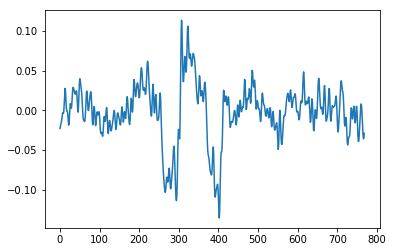

In [87]:
plt.plot(S_new[6])


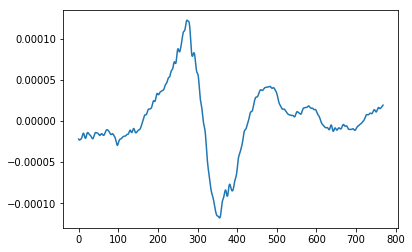

In [88]:
plt.plot(inv_EOG[0][6])